Main libraries 

In [14]:
import functools
from random import random, seed
from itertools import product
import numpy as np
from icecream import ic
from itertools import accumulate
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

Tweak function and multi_Tweak function

In [15]:
def single_tweak( solution: np.ndarray , density: float ) -> np.ndarray: ### check better how works, can give u a warning based on that 
    new_sol= solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]                                             ##### we tweat the solution picking randomly one element and change its sign
    return new_sol                                                          ##### the density input has no effect


def multiple_mutation(solution: np.ndarray , density: float ) -> np.ndarray:
    mask = rng.random(NUM_SETS) < density
    new_solution = np.logical_xor( solution.copy() , mask )                             ### we create a random mask using the density as threshold
    return new_solution                                                                 ### the density is the parameter of exploration that can change over time

Validation function: to safisfy set-cover constraints
Cost function: using the solution we define its cost ( to minimize )

In [16]:
def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype =np.logical_or.reduce(SETS[solution])
    return np.all( phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

Define fitness function

In [ ]:
@counter
def fitness(solution: np.ndarray):  # this is our fitness function, how we evaluate a solution 
    validity = valid(solution)
    cost_func = -cost(solution)
    return (validity, float(cost_func))

Definition of search space dinamically using different hyper-parameter

In [17]:
def createSET_COSTS(NUM_SETS, UNIVERSE_SIZE, DENSITY):
    SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)
    return SETS, COSTS

In [18]:
def experiment( Listobj ):
    global SETS, COSTS , NUM_SETS , UNIVERSE_SIZE , DENSITY , rng
    UNIVERSE_SIZE = Listobj[0]
    NUM_SETS = Listobj[1]
    DENSITY = Listobj[2]

    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int( 10_000 * DENSITY)]))  ##### we have the random function to generate the solution
    SETS, COSTS = createSET_COSTS(NUM_SETS, UNIVERSE_SIZE, DENSITY)                                ##### we create the dataset
    MAX_STEPS = 10_000  
    density_method= 0.01                                                                           #### variable  density_method is the parameter of exploration
                                                                                                   #### will change over time
    solution = rng.random(NUM_SETS) < DENSITY                                                      #### first solution
    call= (0,0)
    start_fitness_call = fitness.calls 
    solution_fitness = fitness(solution)
    history= [(solution_fitness[1],solution_fitness[0] )]

    ic(solution_fitness, np.sum(solution) , fitness.calls)

    tweak =  multiple_mutation                                                                     #### we use as tweak the multi_mutation 
    global_counter=0
    counter=0
    for steps in tqdm(range(MAX_STEPS)):
        new_solution = tweak( solution, density_method)                                            ### we tweak the solution
        f = fitness(new_solution)      
        history.append((f[1],f[0] )) 
        if(solution_fitness[0]==False and f[0]==False):                   ### the algorithm for the first time will check if the starting point is a valid solution
            count_true_sol = np.sum(solution)                              ### if is not a valid solution we count the number of True inside the array, assuming that
            count_true_new_sol = np.sum(new_solution)                      ### more True value we have and more probably the solution will be feasible in few modification
            if(count_true_new_sol> count_true_sol):       # -> we change the solution comparing the True value              
                solution = new_solution
                solution_fitness = f 
                ic(steps ,f , np.sum(solution), fitness.calls) ### u should not add in history
                call = (fitness.calls - start_fitness_call , solution_fitness[1])
                counter=0
        elif f > solution_fitness:                        ### we are replacing the value only if we have a true solution and we get an higher fitness
            solution = new_solution
            solution_fitness = f            # - if we find the correct solution then we decrease the value of the exploration
            ic(steps ,f , np.sum(solution), fitness.calls)  #   of 5%, assuming that we are close to the solution
            density_method= density_method*0.95           
            counter=0
            call = (fitness.calls - start_fitness_call , solution_fitness[1])
        else:
            density_method= density_method*0.95             # we decrease the value of exploration in anyway 
        if(counter > MAX_STEPS*0.02):                       # If we are block in a Local minimum try to increase the value of explaration     
            counter=0                                           
            density_method= density_method+((1-density_method)*0.5) # we compute the new density adding the 5% of 1-X, if for 200 loops we don't find any improvement 
        if(counter > MAX_STEPS*0.06):                       # if increasing the value of exploration doesn't work then change directly the algorithm using
            tweak= single_tweak                             # the single tweak  if for 600 loops we don't see any improvement
        if(global_counter> MAX_STEPS*0.75):         # change the algorithm if we reach 7500 loops, using the single tweak 
            tweak= single_tweak
        global_counter+=1
        counter+=1
    #ic(solution)
    ic(solution_fitness, call)
    #ic(fitness(solution))

    # # Separate the values and booleans
    values = [value for value, is_true in history]
    booleans = [is_true for value, is_true in history]

    # Create a scatter plot
    colors = ['green' if is_true else 'red' for is_true in booleans]
    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(values)),
        list(accumulate(values, max)),
        color="red",
    )
    plt.legend(loc='lower right', fontsize='large', shadow=True, 
               title=f"Hyper-parameter\nUniverse Size {UNIVERSE_SIZE}\nNum. Set {NUM_SETS}\nDensity {DENSITY}\nCalls {call[0]}\nCost {call[1]}")
    _ = plt.scatter(range(len(history)), values, marker=".",color= colors)

In [19]:
# Hyperparameters of experiment
experiment_ele = [ ( 100,  10 ,.2) , (1_000 ,100 ,.2) , ( 10_000, 1_000 ,.2) ,(100_000 ,10_000, .1), (100_000, 10_000 ,.2 ) , (100_000 , 10_000 ,.3)         ]

ic| solution_fitness: (np.False_, -88.62113023507823)
    np.sum(solution): np.int64(3)
    fitness.calls: 33460


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| steps: 10
    f: (np.False_, -121.59974168267752)
    np.sum(solution): np.int64(4)
    fitness.calls: 33471
ic| steps: 24
    f: (np.False_, -157.61368550362982)
    np.sum(solution): np.int64(5)
    fitness.calls: 33485
ic| steps: 27
    f: (np.False_, -192.1069270401602)
    np.sum(solution): np.int64(6)
    fitness.calls: 33488
ic| steps: 45
    f: (np.False_, -237.27743175403646)
    np.sum(solution): np.int64(8)
    fitness.calls: 33506
ic| steps: 51
    f: (np.False_, -268.747712670538)
    np.sum(solution): np.int64(9)
    fitness.calls: 33512
ic| steps: 73
    f: (np.True_, -295.73336962400924)
    np.sum(solution): np.int64(10)
    fitness.calls: 33534
ic| solution_fitness: (np.True_, -295.73336962400924)
    call: (75, -295.73336962400924)
C:\Users\david\AppData\Local\Temp\ipykernel_24888\2152780624.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argumen

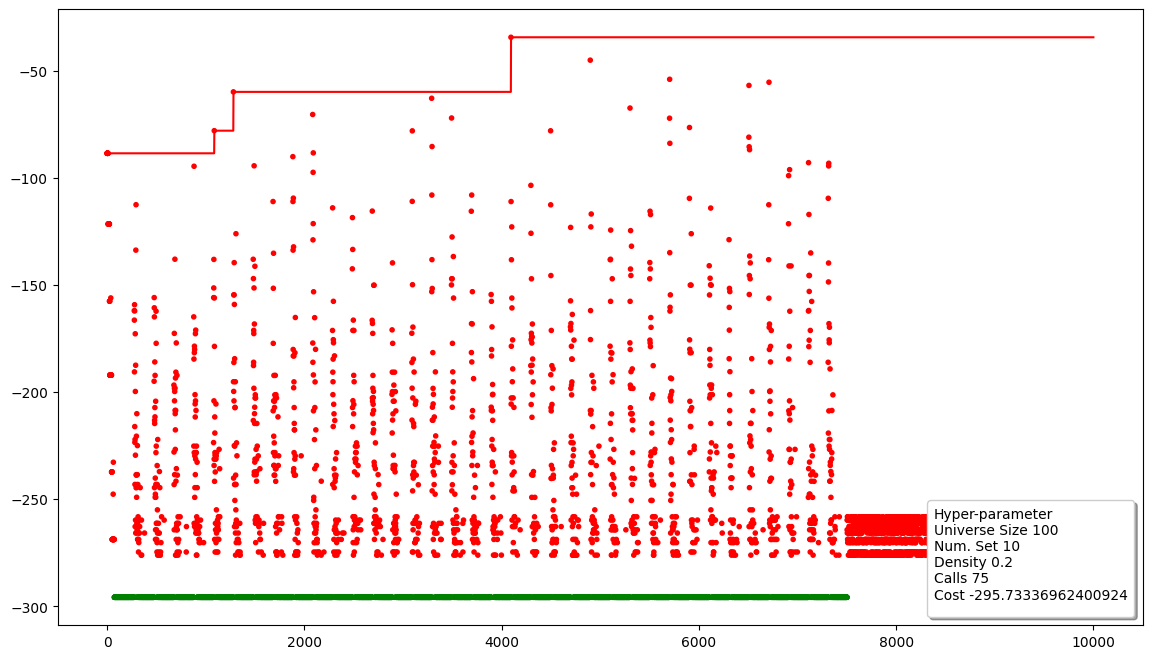

In [20]:
experiment(experiment_ele[0])   

ic| solution_fitness: (np.False_, -6499.615996271695)
    np.sum(solution): np.int64(19)
    fitness.calls: 43461


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| steps: 0
    f: (np.False_, -6835.610141119775)
    np.sum(solution): np.int64(20)
    fitness.calls: 43462
ic| steps: 4
    f: (np.False_, -7179.07831920087)
    np.sum(solution): np.int64(21)
    fitness.calls: 43466
ic| steps: 6
    f: (np.False_, -7528.161759316443)
    np.sum(solution): np.int64(22)
    fitness.calls: 43468
ic| steps: 7
    f: (np.False_, -8230.370887155204)
    np.sum(solution): np.int64(24)
    fitness.calls: 43469
ic| steps: 8
    f: (np.False_, -8588.831319453124)
    np.sum(solution): np.int64(25)
    fitness.calls: 43470
ic| steps: 13
    f: (np.False_, -8906.206991999421)
    np.sum(solution): np.int64(26)
    fitness.calls: 43475
ic| steps: 14
    f: (np.False_, -9602.66796626335)
    np.sum(solution): np.int64(28)
    fitness.calls: 43476
ic| steps: 18
    f: (np.False_, -9920.04363880965)
    np.sum(solution): np.int64(29)
    fitness.calls: 43480
ic| steps: 19
    f: (np.False_, -10250.442143017333)
    np.sum(solution): np.int64(30)
    fitness.cal

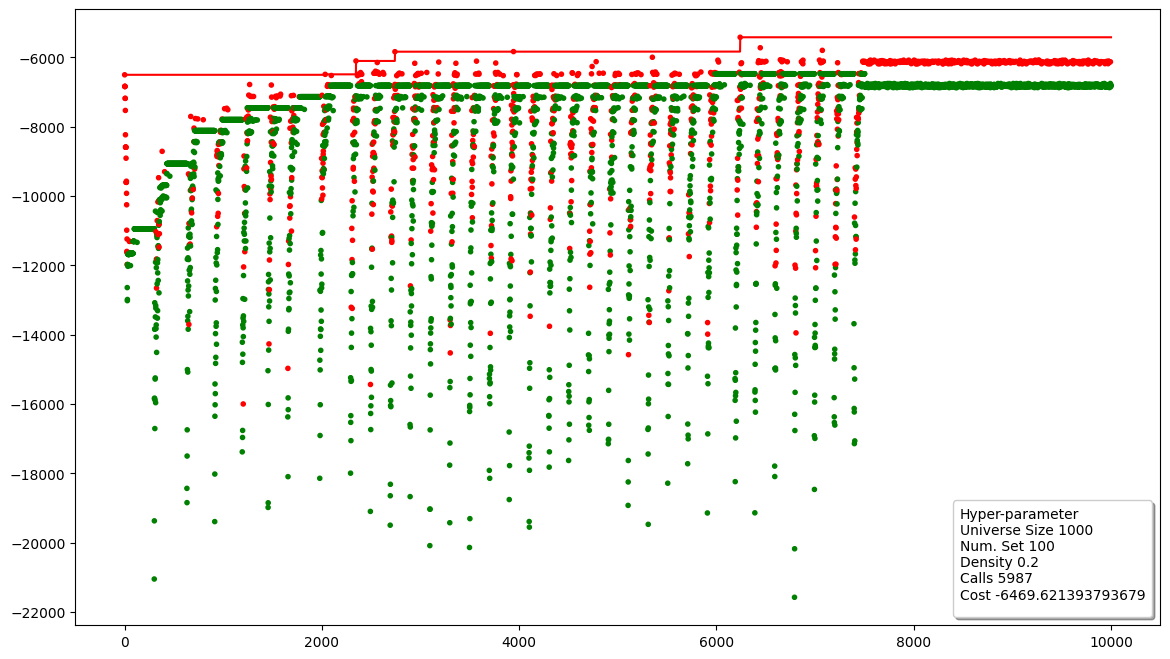

In [21]:
experiment(experiment_ele[1])

ic| solution_fitness: (np.True_, -799011.6868153699)
    np.sum(solution): np.int64(187)
    fitness.calls: 53462


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| steps: 18
    f: (np.True_, -794720.3644087424)
    np.sum(solution): np.int64(186)
    fitness.calls: 53481
ic| steps: 24
    f: (np.True_, -790314.0021842851)
    np.sum(solution): np.int64(185)
    fitness.calls: 53487
ic| steps: 28
    f: (np.True_, -786081.7293936104)
    np.sum(solution): np.int64(184)
    fitness.calls: 53491
ic| steps: 34
    f: (np.True_, -785992.2569421544)
    np.sum(solution): np.int64(184)
    fitness.calls: 53497
ic| steps: 339
    f: (np.True_, -781585.7647104384)
    np.sum(solution): np.int64(183)
    fitness.calls: 53802
ic| steps: 355
    f: (np.True_, -777470.853192027)
    np.sum(solution): np.int64(182)
    fitness.calls: 53818
ic| steps: 357
    f: (np.True_, -773165.6785454841)
    np.sum(solution): np.int64(181)
    fitness.calls: 53820
ic| steps: 364
    f: (np.True_, -768928.7124805606)
    np.sum(solution): np.int64(180)
    fitness.calls: 53827
ic| steps: 369
    f: (np.True_, -764684.6949556405)
    np.sum(solution): np.int64(179)
    

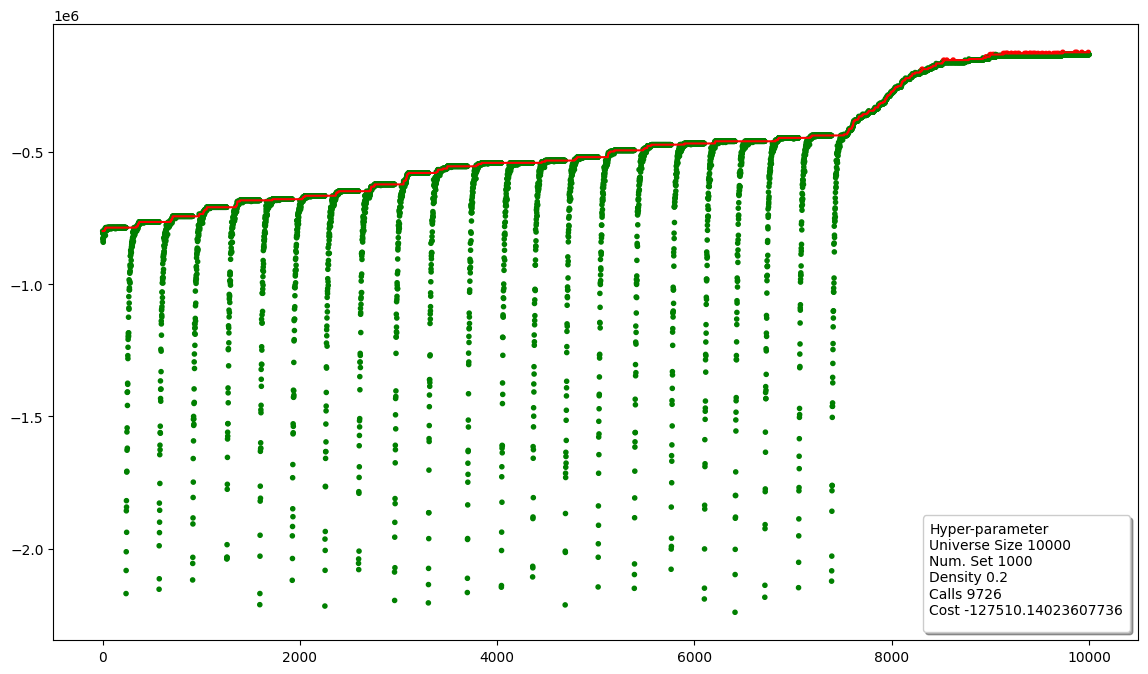

In [22]:
experiment(experiment_ele[2])

ic| solution_fitness: (np.True_, -24257652.577183228)
    np.sum(solution): np.int64(966)
    fitness.calls: 63463


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| steps: 100
    f: (np.True_, -24232497.79055827)
    np.sum(solution): np.int64(965)
    fitness.calls: 63564
ic| steps: 113
    f: (np.True_, -24207644.053759478)
    np.sum(solution): np.int64(964)
    fitness.calls: 63577
ic| steps: 466
    f: (np.True_, -24207113.289975263)
    np.sum(solution): np.int64(964)
    fitness.calls: 63930
ic| steps: 469
    f: (np.True_, -24206336.749585472)
    np.sum(solution): np.int64(964)
    fitness.calls: 63933
ic| steps: 483
    f: (np.True_, -24181085.225881897)
    np.sum(solution): np.int64(963)
    fitness.calls: 63947
ic| steps: 498
    f: (np.True_, -24155734.166023917)
    np.sum(solution): np.int64(962)
    fitness.calls: 63962
ic| steps: 518
    f: (np.True_, -24130888.71033267)
    np.sum(solution): np.int64(961)
    fitness.calls: 63982
ic| steps: 887
    f: (np.True_, -24080415.84998805)
    np.sum(solution): np.int64(959)
    fitness.calls: 64351
ic| steps: 920
    f: (np.True_, -24055385.389914803)
    np.sum(solution): np.int6

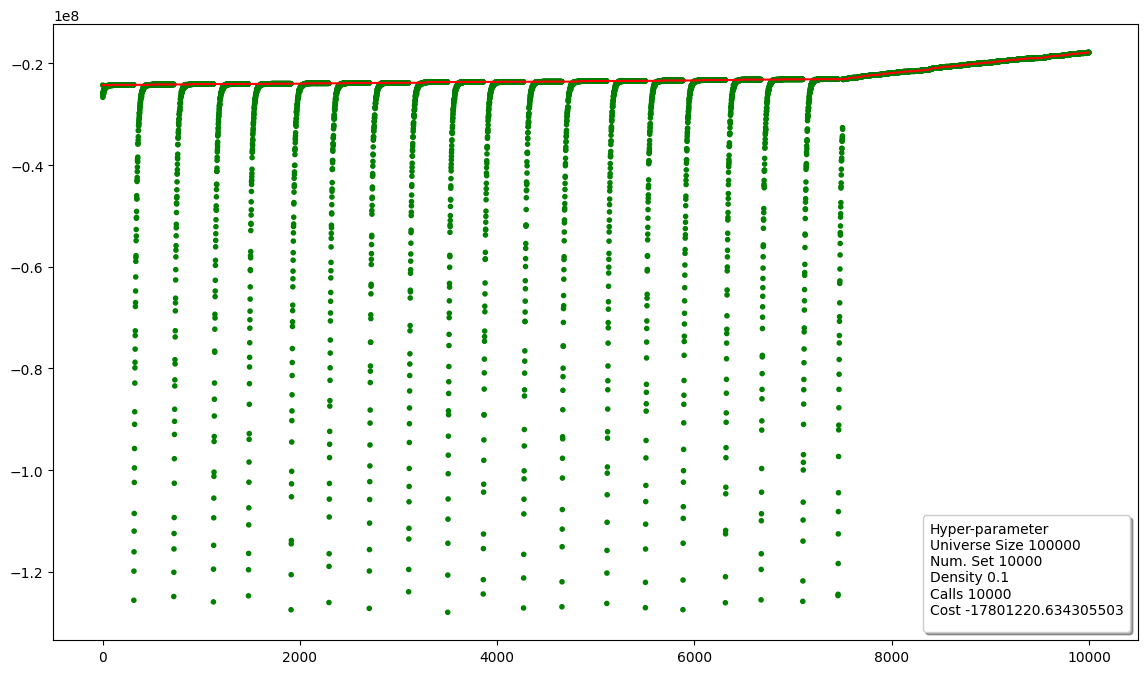

In [23]:
experiment(experiment_ele[3])

ic| solution_fitness: (np.True_, -110014697.2558974)
    np.sum(solution): np.int64(2043)
    fitness.calls: 73464


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| steps: 60
    f: (np.True_, -109906648.95388949)
    np.sum(solution): np.int64(2041)
    fitness.calls: 73525
ic| steps: 75
    f: (np.True_, -109852835.10269049)
    np.sum(solution): np.int64(2040)
    fitness.calls: 73540
ic| steps: 80
    f: (np.True_, -109798490.9524085)
    np.sum(solution): np.int64(2039)
    fitness.calls: 73545
ic| steps: 91
    f: (np.True_, -109636278.94618008)
    np.sum(solution): np.int64(2036)
    fitness.calls: 73556
ic| steps: 99
    f: (np.True_, -109529030.1892612)
    np.sum(solution): np.int64(2034)
    fitness.calls: 73564
ic| steps: 438
    f: (np.True_, -109475286.73580995)
    np.sum(solution): np.int64(2033)
    fitness.calls: 73903
ic| steps: 444
    f: (np.True_, -109421200.38770187)
    np.sum(solution): np.int64(2032)
    fitness.calls: 73909
ic| steps: 452
    f: (np.True_, -109367969.92829075)
    np.sum(solution): np.int64(2031)
    fitness.calls: 73917
ic| steps: 487
    f: (np.True_, -109314170.88311875)
    np.sum(solution): np.

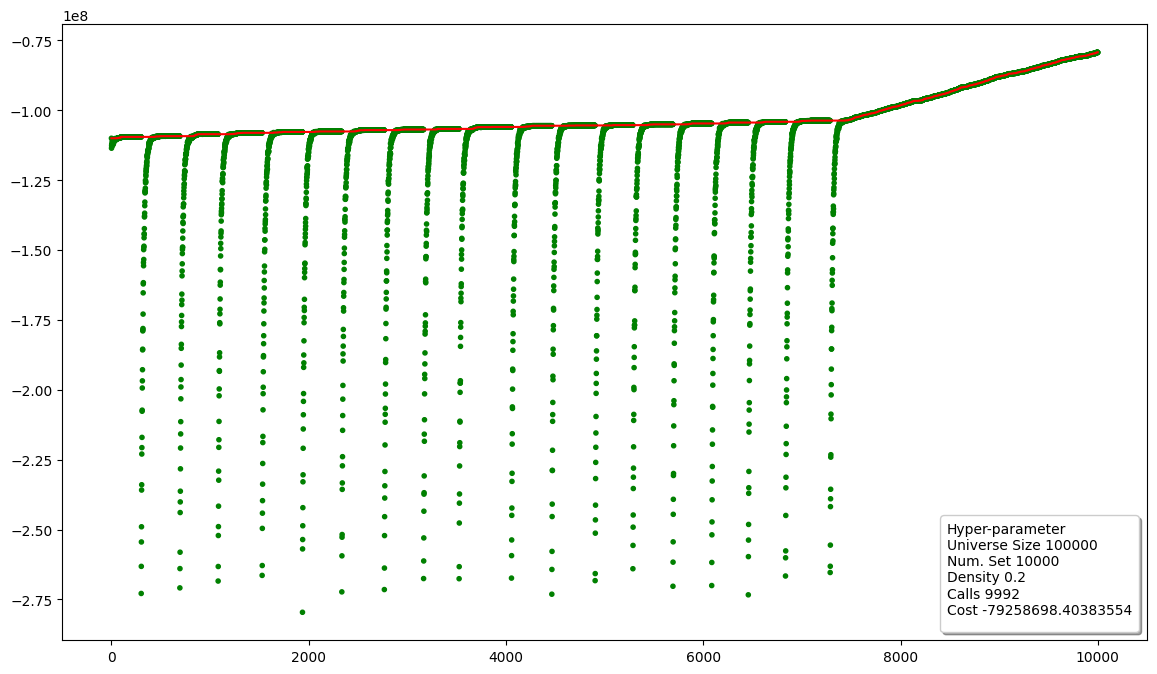

In [24]:
experiment(experiment_ele[4])

ic| solution_fitness: (np.True_, -254262065.58591357)
    np.sum(solution): np.int64(3023)
    fitness.calls: 83465


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| steps: 33
    f: (np.True_, -254177366.32673973)
    np.sum(solution): np.int64(3022)
    fitness.calls: 83499
ic| steps: 63
    f: (np.True_, -254175504.35027435)
    np.sum(solution): np.int64(3022)
    fitness.calls: 83529
ic| steps: 66
    f: (np.True_, -254175004.96355397)
    np.sum(solution): np.int64(3022)
    fitness.calls: 83532
ic| steps: 75
    f: (np.True_, -254090684.9080809)
    np.sum(solution): np.int64(3021)
    fitness.calls: 83541
ic| steps: 77
    f: (np.True_, -254090428.9148583)
    np.sum(solution): np.int64(3021)
    fitness.calls: 83543
ic| steps: 88
    f: (np.True_, -254007421.98149818)
    np.sum(solution): np.int64(3020)
    fitness.calls: 83554
ic| steps: 130
    f: (np.True_, -253923240.7244649)
    np.sum(solution): np.int64(3019)
    fitness.calls: 83596
ic| steps: 445
    f: (np.True_, -253668463.42952)
    np.sum(solution): np.int64(3016)
    fitness.calls: 83911
ic| steps: 456
    f: (np.True_, -253584063.67511508)
    np.sum(solution): np.int64

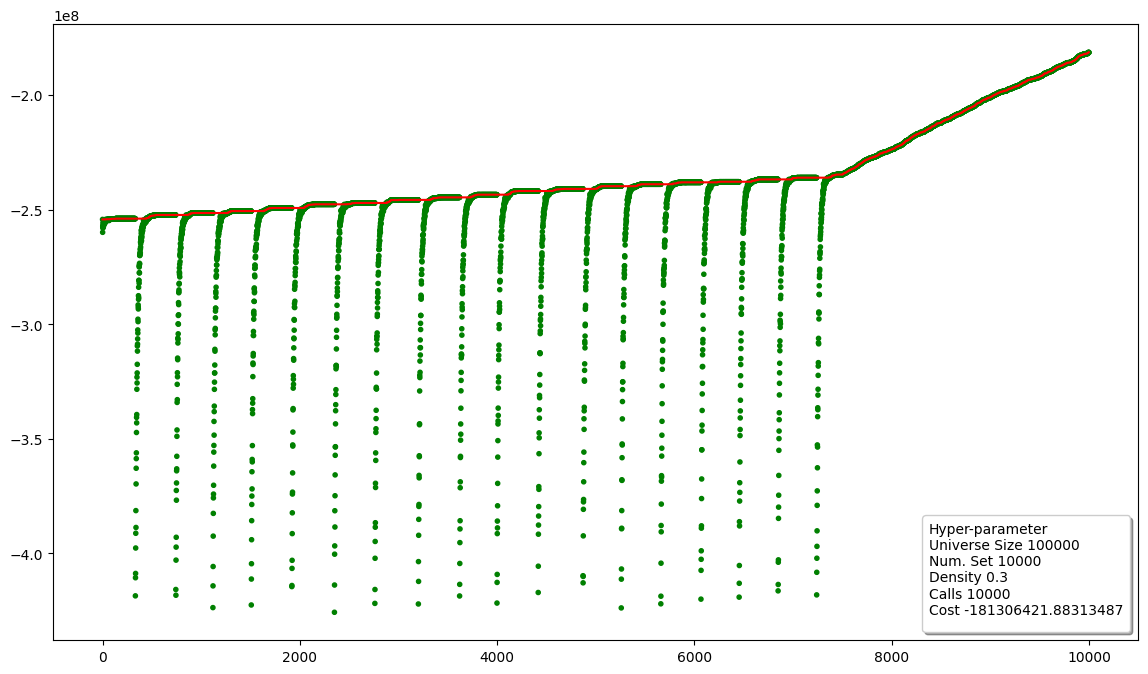

In [25]:
experiment(experiment_ele[5])